In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import (models, initializers as init, 
                              layers, backend as K, regularizers as reg)
from tensorflow.keras.datasets import mnist

from sklearn.metrics import mean_squared_error

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [4]:
x_train.shape

(60000, 28, 28)

In [5]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [6]:
print(x_train.shape, x_test.shape)

(60000, 784) (10000, 784)


In [7]:
#https://github.com/sudharsan13296/Hands-On-Deep-Learning-Algorithms-with-Python/tree/master/10. Reconsturcting Inputs using Autoencoders
def sparse_regularizer(activation_matrix):
    p = 0.05
    α = 1

    p_hat = K.mean(activation_matrix) 

    KL_divergence = p*(K.log(p/p_hat)) + (1-p)*(K.log(1-p/1-p_hat))
    
    summation = K.sum(KL_divergence) 
   
    return α * summation

In [9]:
λ = 0.01
class SparseAutoencoder(models.Model):
    def __init__(self, orig_units, hidden_units):
        super(SparseAutoencoder, self).__init__()
        self.enc = models.Sequential([
            layers.Dense(
                hidden_units, 
                activation="sigmoid", 
                kernel_regularizer=reg.l2(λ),
                activity_regularizer=sparse_regularizer
            )
        ])
        self.dec = models.Sequential([
            layers.Dense(
                orig_units,
                activation="sigmoid",
                kernel_regularizer=reg.l2(λ),
                activity_regularizer=sparse_regularizer
            )
        ])
        
    def call(self, x):
        encoded = self.enc(x)
        decoded = self.dec(encoded)
        return decoded

In [10]:
sac = SparseAutoencoder(784, 400)

In [11]:
sac.compile(optimizer="sgd", loss="mse")

In [14]:
sac.fit(x_train, x_train, batch_size=128, shuffle=True, epochs=10, validation_data=(x_test, x_test))

Epoch 1/10
469/469 [==============================] - 4s 8ms/step - loss: 0.3735 - val_loss: 0.3527
Epoch 2/10
469/469 [==============================] - 4s 8ms/step - loss: 0.3346 - val_loss: 0.3174
Epoch 3/10
469/469 [==============================] - 4s 8ms/step - loss: 0.3024 - val_loss: 0.2880
Epoch 4/10
469/469 [==============================] - 4s 8ms/step - loss: 0.2756 - val_loss: 0.2637
Epoch 5/10
469/469 [==============================] - 4s 8ms/step - loss: 0.2534 - val_loss: 0.2436
Epoch 6/10
469/469 [==============================] - 4s 9ms/step - loss: 0.2350 - val_loss: 0.2268
Epoch 7/10
469/469 [==============================] - 4s 8ms/step - loss: 0.2198 - val_loss: 0.2130
Epoch 8/10
469/469 [==============================] - 4s 9ms/step - loss: 0.2071 - val_loss: 0.2015
Epoch 9/10
469/469 [==============================] - 4s 8ms/step - loss: 0.1966 - val_loss: 0.1919
Epoch 10/10
469/469 [==============================] - 4s 8ms/step - loss: 0.1879 - val_loss: 0.1840

In [15]:
t = sac.predict(x_train)

1875/1875 [==============================] - 4s 2ms/step


In [16]:
mean_squared_error(x_train, t, squared=False)

0.34421387

Text(0.5, 1.0, 'Reconstructed Image')

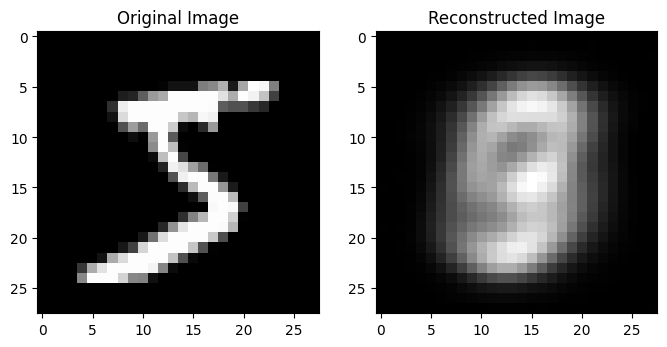

In [17]:
i=0
f, ax = plt.subplots(1,2, figsize=(8,5))
ax[0].imshow(x_train[i].reshape(28,28), cmap="gray")
ax[0].set_title("Original Image")

ax[1].imshow(t[i].reshape(28,28), cmap="gray")
ax[1].set_title("Reconstructed Image")

In [52]:
pred = sac.predict(x_test)

313/313 [==============================] - 1s 2ms/step


In [53]:
mean_squared_error(x_test, pred, squared=False)

0.35125482

Text(0.5, 1.0, 'Reconstructed Image')

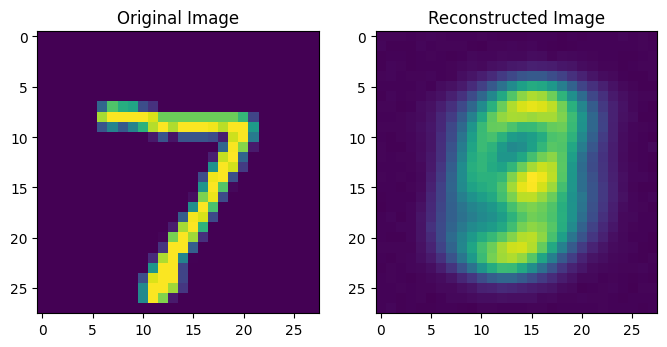

In [54]:
f, ax = plt.subplots(1,2, figsize=(8,5))
ax[0].imshow(x_test[0].reshape(28,28))
ax[0].set_title("Original Image")

ax[1].imshow(pred[0].reshape(28,28))
ax[1].set_title("Reconstructed Image")

In [22]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [41]:
sac.enc.trainable=True

In [42]:
model = models.Sequential([
    sac.enc,
    layers.Dense(10, activation="softmax")
])

In [43]:
model.compile("adam", "sparse_categorical_crossentropy")

In [44]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [56]:
model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), batch_size=64, epochs=2)

Epoch 1/2
938/938 [==============================] - 8s 8ms/step - loss: 0.6564 - val_loss: 0.6399
Epoch 2/2
938/938 [==============================] - 7s 7ms/step - loss: 0.6212 - val_loss: 0.5698


In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [57]:
pred = model.predict(x_test)

313/313 [==============================] - 1s 2ms/step


In [58]:
pred = np.argmax(pred, axis=1)

In [59]:
accuracy_score(y_test, pred)

0.8935

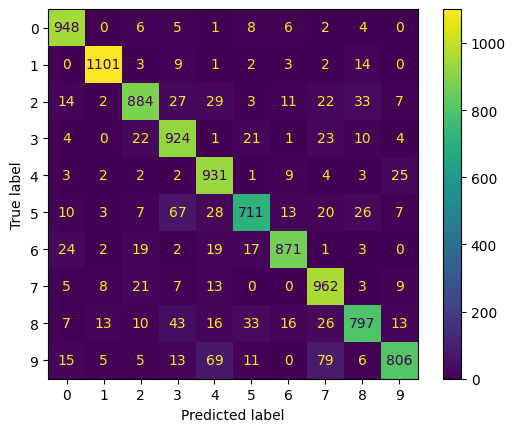

In [61]:
ConfusionMatrixDisplay(confusion_matrix(y_test, pred)).plot()